In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *

In [2]:
indir = '~/BC-fMRI-AE/Assets/data_preprocessed_f3/'
indir = os.path.expanduser(indir)

In [3]:
folders = os.listdir(indir)
folders.sort()
folders_names = [int(folder[-5::]) for folder in folders]

In [4]:
sub_list = pd.DataFrame()
sub_list['subID'] = folders
sub_list['subNum'] = folders_names

In [5]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [6]:
#pd.DataFrame(folders).to_csv('../Data/lo.csv')

In [7]:
len(folders)

2100

In [8]:
# Load the data

fn_temp = '~/BC-fMRI-AE/Assets/data_preprocessed_f3/{sub}/'
fn_temp = os.path.expanduser(fn_temp)

cmats = []
durations = []
cmats_rel1 = []
cmats_rel2 = []
for i,sub in tqdm(enumerate(folders)):
    cmats.append(np.load(os.path.join(fn_temp,'cmat_srf_{sub}.npy').format(sub=sub)))
    durations.append(np.load(os.path.join(fn_temp,'scan_duration_{sub}.npy').format(sub=sub)))
    try:
        cmats_rel1.append(np.load(os.path.join(fn_temp,'split_data_srf{sub}.npz').format(sub=sub))['cmat1'])
        cmats_rel2.append(np.load(os.path.join(fn_temp,'split_data_srf{sub}.npz').format(sub=sub))['cmat2'])
    except:
        cmats_rel1.append(np.zeros((51,51))*np.nan)
        cmats_rel2.append(np.zeros((51,51))*np.nan)
        
        
durations = np.array(durations)
cmats = np.array(cmats)
cmats_rel1 = np.array(cmats_rel1)
cmats_rel2 = np.array(cmats_rel2)

241it [00:04, 52.94it/s]Exception ignored in: <function NpzFile.__del__ at 0x1554b03528b0>
Traceback (most recent call last):
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py", line 221, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
1844it [00:37, 55.03it/s]Exception ignored in: <function NpzFile.__del__ at 0x1554b03528b0>
Traceback (most recent call last):
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py", line 221, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
2100it [00:42, 49.76it/s]


In [9]:
(durations>4).sum()

1668

In [10]:
sub_list['duration'] = durations

6


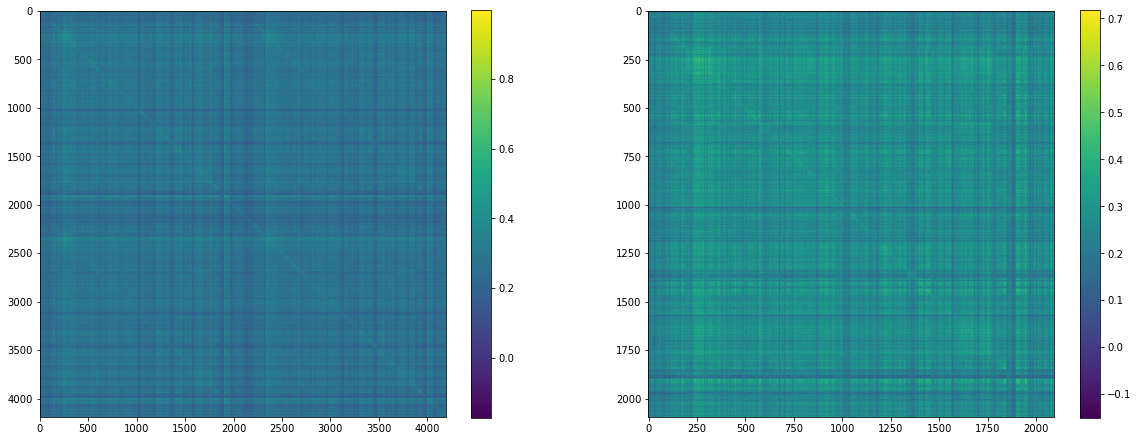

In [11]:
rel_cmat_flat_1 = flatten_cmat(cmats_rel1)
rel_cmat_flat_2 = flatten_cmat(cmats_rel2)

e = np.isnan(rel_cmat_flat_1).sum(axis=1)+np.isnan(rel_cmat_flat_2).sum(axis=1)>0
sub_list['rel_nan'] = e
print(e.sum())

rel_cmat_flat_1 = rel_cmat_flat_1[~e,:]
rel_cmat_flat_2 = rel_cmat_flat_2[~e,:]
n = rel_cmat_flat_1.shape[0]

rel_sim = np.corrcoef(np.vstack((rel_cmat_flat_1,rel_cmat_flat_2)))
sim_halves = rel_sim[0:n,n::]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(rel_sim)
plt.clim(get_triu(rel_sim).min(),get_triu(rel_sim).max())
plt.colorbar(shrink=.75)

#plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(sim_halves)
plt.clim(get_triu(sim_halves).min(),get_triu(sim_halves).max())
plt.colorbar(shrink=.75)

In [12]:
ranks = np.array([np.argwhere(np.argsort(sim_halves[s,:])[-1::-1]==s)[0][0]+1 for s in range(n)])

In [13]:
sub_list['rank'] = np.nan
sub_list['rank'].values[~e] = ranks

In [14]:
np.median(ranks)

7.0

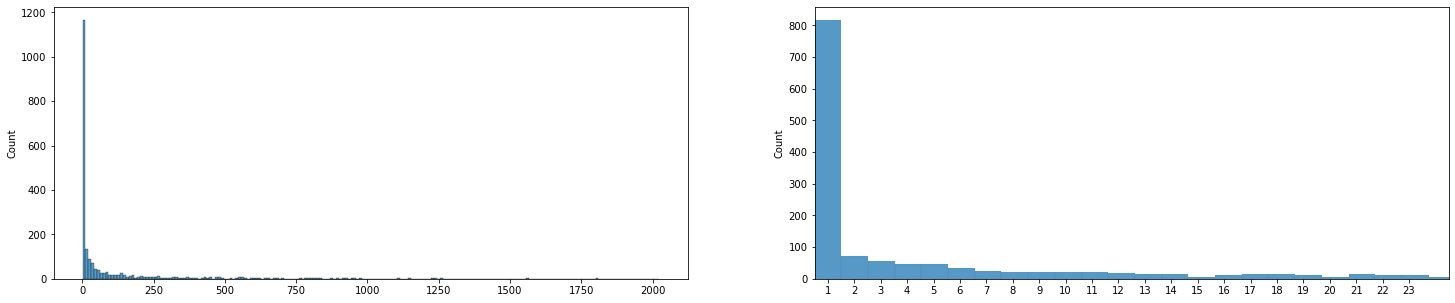

In [15]:
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.histplot(ranks,bins=200)
plt.subplot(1,2,2)
sns.histplot(ranks,bins=2000)
plt.xlim(1,25);
plt.xticks(np.arange(1,24)+.5,labels=np.arange(1,24));

In [16]:
good_cmats = np.isnan(cmats).sum(axis=-1).sum(axis=-1)==0
sub_list['cmat_nan'] = ~good_cmats

In [17]:
cmats = cmats[good_cmats]

Text(0.5, 1.0, 'cmat similarity')

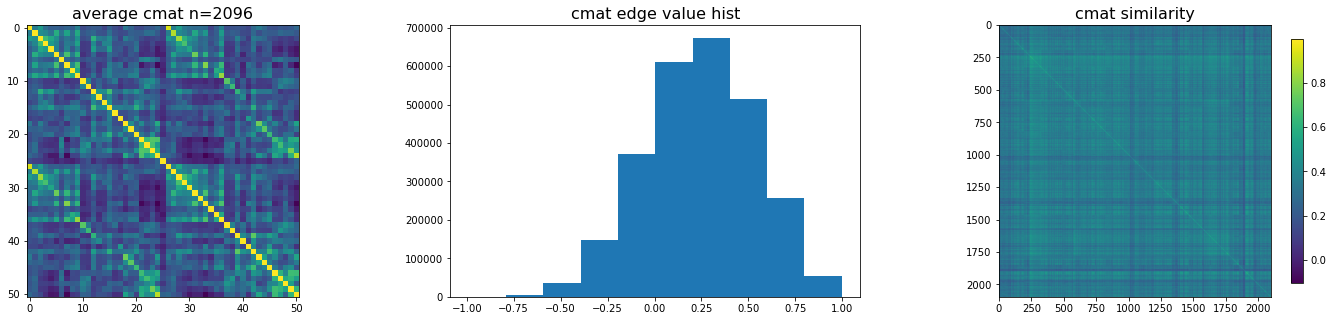

In [18]:
plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.imshow(cmats.mean(axis=0))
plt.title(f'average cmat n={cmats.shape[0]}',fontsize=16)

plt.subplot(1,3,2)
triu = np.triu_indices(n=51,k=1)
cmats_flat = np.array([cmats[i,:,:][triu] for i in range(cmats.shape[0])])
plt.hist(cmats_flat.flatten())
plt.title('cmat edge value hist',fontsize=16)


plt.subplot(1,3,3)
subcmat = np.corrcoef(cmats_flat)
subcmat_vec = subcmat[np.triu_indices(subcmat.shape[0],k=1)]

#plt.figure(figsize=(10,10))
plt.imshow(subcmat,vmin=subcmat_vec.min(),vmax=subcmat_vec.max())
plt.colorbar(shrink=.9)
plt.title('cmat similarity',fontsize=16)

In [19]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [20]:
rlbls = pd.read_csv('../Data/YeoAtlas/roinames.txt',header=None,names=['rlbl'])['rlbl'].values

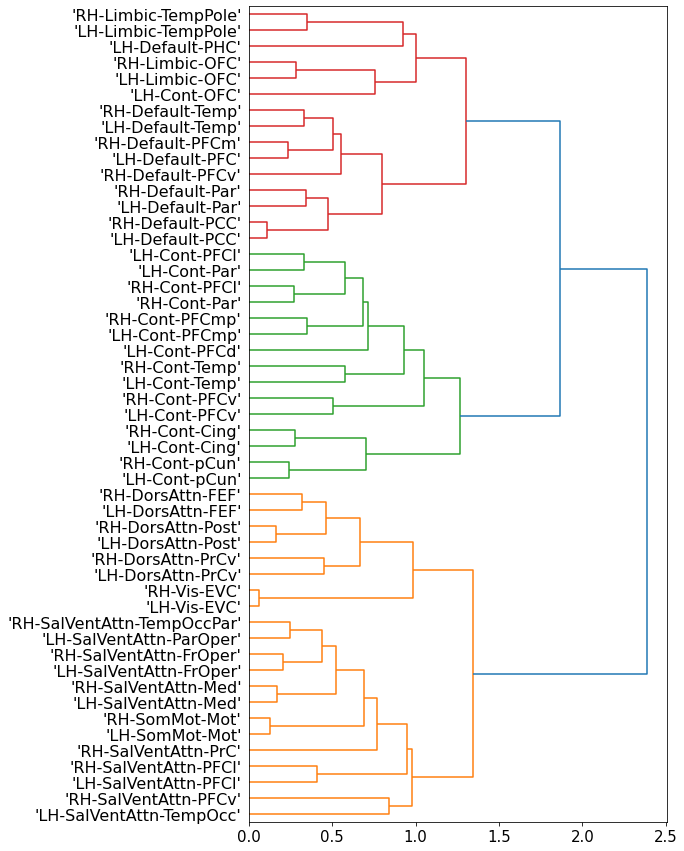

In [21]:
Z = linkage(1-get_triu(cmats.mean(axis=0)),'ward')
plt.figure(figsize=np.array((5,10))*1.5)
dendrogram(Z,orientation='right',labels=rlbls);
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=16)

In [22]:
fmriprep_check = pd.read_csv('../Data/fmriprep_check.csv')
dataset = [fmriprep_check['dataset'].values[fmriprep_check['subID'].values==sub][0] for sub in sub_list['subID'].values]
sub_list['dataset'] = dataset

In [23]:
u,c = np.unique(sub_list['subNum'].values,return_counts=True)
sub_list['scaned_twice'] = sub_list['subNum'].isin(u[c>1])
print(len(u[c>1]))

32


In [24]:
sub_list.to_csv('../Data/sub_list_preprocessed4.csv')

In [25]:
## Concatenate legends

In [26]:
unify = pd.read_csv('../Data/unify_abide_labels.csv')
df_ab2 = pd.read_csv('../Data/ABIDE2_df.csv')
df_ab1 = pd.read_csv('../Data/ABIDE_df3.csv')

df_ab1_unified = df_ab1[unify['ABIDE1_label'].values].copy()
df_ab1_unified = df_ab1_unified.set_axis(unify['unified_label'].values, axis=1, inplace=False)

df_ab2_unified = df_ab2[unify['ABIDE2_label'].values].copy()
df_ab2_unified = df_ab2_unified.set_axis(unify['unified_label'].values, axis=1, inplace=False)

In [27]:
df_ab1_unified['dataset'] = 'ABIDE1'
df_ab2_unified['dataset'] = 'ABIDE2'

In [28]:
df_comb = pd.concat([df_ab1_unified,df_ab2_unified])
df_comb.sort_values(by=['dataset','subID'],ascending=True,inplace=True)
#df_comb.to_csv('../Data/df_comb_S2055.csv')
df_comb

,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,viq,piq,...,srs_cognition,srs_comm,srs_motyvation,srs_mannerisms,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset
0,50002,1,1.0,16.77,1,Ambi,NaN,103.0,116.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
1,50003,1,1.0,24.45,1,R,NaN,124.0,128.0,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
2,50004,1,1.0,19.09,1,R,NaN,113.0,108.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
3,50005,1,1.0,13.73,2,R,NaN,119.0,117.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
4,50006,1,1.0,13.37,1,L,NaN,109.0,99.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,30163,2,NaN,8.00,2,1,81.25,136.0,NaN,NaN,...,1.0,1.0,8.0,2.0,1.0,NaN,none,NaN,NaN,ABIDE2
747,30164,2,NaN,10.00,2,1,100.00,115.0,NaN,NaN,...,5.0,6.0,1.0,4.0,2.0,NaN,none,NaN,NaN,ABIDE2
748,30165,2,NaN,12.00,2,1,100.00,120.0,NaN,NaN,...,1.0,1.0,0.0,0.0,NaN,NaN,none,NaN,NaN,ABIDE2
749,30166,2,NaN,10.00,2,1,100.00,112.0,NaN,NaN,...,5.0,5.0,7.0,6.0,4.0,NaN,tourettes/tics,NaN,NaN,ABIDE2


In [29]:
# Add scan-site information
subsite = []

abide1_path = '~/data/ABIDE/RawDataBIDS/'
abide2_path = '~/data/ABIDE2/RawData/'

abide1_path = os.path.expanduser(abide1_path)
abide2_path = os.path.expanduser(abide2_path)

abide1_sites = os.listdir(abide1_path)
abide1_sites.sort()

abide2_sites = [folder for folder in os.listdir(abide2_path) if not folder.startswith('.')]
abide2_sites.sort()

# ABIDE I
for site in abide1_sites:
    site_subs = [sub for sub in os.listdir(os.path.join(abide1_path,site)) if sub.startswith('sub-')]
    for site_sub in site_subs:
        subsite.append([site_sub,site])
        
# ABIDE II
for site in abide2_sites:
    site_subs = [sub for sub in os.listdir(os.path.join(abide2_path,site)) if sub.startswith('sub-')]
    for site_sub in site_subs:
        subsite.append([site_sub,site.replace('ABIDEII-','')])
        
subsite = pd.DataFrame(subsite,columns=['sub','site'])

In [30]:
unique_sites = np.unique(subsite['site'].values)
unique_sites.sort()
subsite['siteID'] = [np.argwhere(subsite['site'].values[s]==unique_sites)[0][0]+1 for s,_ in enumerate(subsite['site'])]
subsite['subNum'] = [int(sub[-5::]) for sub in subsite['sub'].values]

In [31]:
len(np.unique(subsite['sub'].values))

2194

In [32]:
subsite.sort_values(by="sub", ascending=1)

,sub,site,siteID,subNum
507,sub-0050002,Pitt,26,50002
521,sub-0050003,Pitt,26,50003
528,sub-0050004,Pitt,26,50004
542,sub-0050005,Pitt,26,50005
518,sub-0050006,Pitt,26,50006
...,...,...,...,...
2141,sub-51300,UCLA_Long,36,51300
2132,sub-51307,UCLA_Long,36,51307
2138,sub-51312,UCLA_Long,36,51312
2140,sub-51313,UCLA_Long,36,51313


In [33]:
sub_list = pd.read_csv('../Data/sub_list_preprocessed4.csv')
df_comb = pd.read_csv('../Data/df_comb_S2055.csv')

In [34]:
use_subjects = (~sub_list['scaned_twice'].values) * (~sub_list['cmat_nan'].values) * (sub_list['duration'].values>=4)
sub_list_use = sub_list.iloc[use_subjects]

In [35]:
print(len(sub_list_use))
sub_list_use.head(5)

1640


,Unnamed: 0,subID,subNum,duration,rel_nan,rank,cmat_nan,dataset,scaned_twice
2,2,sub-0050004,50004,4.075,False,1636.0,False,ABIDE I,False
8,8,sub-0050010,50010,4.600,False,523.0,False,ABIDE I,False
9,9,sub-0050011,50011,4.775,False,3.0,False,ABIDE I,False
10,10,sub-0050012,50012,4.050,False,710.0,False,ABIDE I,False
12,12,sub-0050014,50014,4.950,False,2.0,False,ABIDE I,False


In [36]:
print(len(df_comb))
df_comb.head(5)

2055


,Unnamed: 0,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,viq,...,srs_cognition,srs_comm,srs_motyvation,srs_mannerisms,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset
0,0,50002,1,1.0,16.77,1,Ambi,NaN,103.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
1,1,50003,1,1.0,24.45,1,R,NaN,124.0,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
2,2,50004,1,1.0,19.09,1,R,NaN,113.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
3,3,50005,1,1.0,13.73,2,R,NaN,119.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
4,4,50006,1,1.0,13.37,1,L,NaN,109.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1


In [37]:
assert np.unique(sub_list_use['subNum'].values,return_counts=True)[1].max()==1,'duplicate subjects in sub_list_use'
assert np.unique(df_comb['subID'].values,return_counts=True)[1].max()==1,'duplicate subjects in df_comb'

In [38]:
stack_subs = np.hstack(( sub_list_use['subNum'].values , df_comb['subID'].values ))
unique_subs, count = np.unique(stack_subs,return_counts=True)
common_subs = unique_subs[count==2]
print(len(common_subs))

1558


In [39]:
df_comb_use = df_comb.iloc[df_comb['subID'].isin(common_subs).values]
df_comb_use

,Unnamed: 0,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,viq,...,srs_cognition,srs_comm,srs_motyvation,srs_mannerisms,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset
2,2,50004,1,1.0,19.09,1,R,NaN,113.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
8,8,50010,1,1.0,35.20,1,L,NaN,81.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
9,9,50011,1,1.0,16.93,1,L,NaN,111.0,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
10,10,50012,1,1.0,21.48,1,R,NaN,128.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
12,12,50014,1,1.0,14.20,1,R,NaN,96.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABIDE1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,746,30163,2,NaN,8.00,2,1.0,81.25,136.0,NaN,...,1.0,1.0,8.0,2.0,1.0,NaN,none,NaN,NaN,ABIDE2
2051,747,30164,2,NaN,10.00,2,1.0,100.00,115.0,NaN,...,5.0,6.0,1.0,4.0,2.0,NaN,none,NaN,NaN,ABIDE2
2052,748,30165,2,NaN,12.00,2,1.0,100.00,120.0,NaN,...,1.0,1.0,0.0,0.0,NaN,NaN,none,NaN,NaN,ABIDE2
2053,749,30166,2,NaN,10.00,2,1.0,100.00,112.0,NaN,...,5.0,5.0,7.0,6.0,4.0,NaN,tourettes/tics,NaN,NaN,ABIDE2


In [40]:
df_comb_use['siteID'] = [subsite[df_comb_use['subID'].values[s]==subsite['subNum'].values]['siteID'].values[0] for s in range(df_comb_use.shape[0])]

<ipython-input-40-df6ef4c9be6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_use['siteID'] = [subsite[df_comb_use['subID'].values[s]==subsite['subNum'].values]['siteID'].values[0] for s in range(df_comb_use.shape[0])]


In [64]:
def make_subID(s,df):
    subNum = df['subID'].values[s]
    subID = [f'sub-00{subNum:}' if df['dataset'].values[s]=='ABIDE1' else f'sub-{subNum:}'][0]
    return subID

In [65]:
df_comb_use['sub'] = [make_subID(s,df_comb_use) for s in range(df_comb_use.shape[0])]

<ipython-input-65-4bfa4d221648>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_use['sub'] = [make_subID(s,df_comb_use) for s in range(df_comb_use.shape[0])]


In [73]:
cmats = [np.load(f'../Assets/data_preprocessed_f3/{sub}/cmat_srf_{sub}.npy') for sub in tqdm(df_comb_use['sub'].values)]

100%|██████████| 1558/1558 [00:10<00:00, 145.54it/s]


In [74]:
df_comb_use.to_csv('../Data/df_comb_S1558.csv')

In [ ]:
np.savez_compressed('../Data/cmats')

In [ ]:
'../df_comb_S1558.csv'